In [33]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


# Loading dataset

In [34]:
data_path = "data/playground_data.csv"

In [35]:
df_model = pd.read_csv(data_path).fillna("")

In [36]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [37]:
# Candidate covariates; we keep the ones that exist in df
candidate_covars = ["cmpl_complex", "cmpl_anim", "cmpl_det", "cmpl_def", "cmpl_indiv", "motion_type"]

# Encoding important variables

In [38]:
# Ensure key columns exist
for col in ["cmpl_constr", "book_scroll", "lex"]:
    assert col in df_model.columns, f"Missing column: {col}"

In [39]:
# Encode outcome variable as categorical indices (pandas type) (no special reference; sum-to-zero)
df_model["cmpl_constr"] = df_model["cmpl_constr"].astype("category")
class_labels = df_model["cmpl_constr"].cat.categories.tolist()
K = len(class_labels)
y = df_model["cmpl_constr"].cat.codes.values  # 0..K-1

In [40]:
# Encode grouping factors as categorical indices
df_model["book_scroll"] = df_model["book_scroll"].astype("category")
df_model["lex"] = df_model["lex"].astype("category")

In [41]:
book_labels = df_model["book_scroll"].cat.categories.tolist()
verb_labels = df_model["lex"].cat.categories.tolist()
B = len(book_labels)
V = len(verb_labels)

In [42]:
book_idx = df_model["book_scroll"].cat.codes.values.astype("int32")
verb_idx = df_model["lex"].cat.codes.values.astype("int32")

In [43]:
# --- Build design matrix X for covariates
have_covars = [c for c in candidate_covars if c in df_model.columns]
X_df_parts = []

for c in have_covars:
    s = df_model[c]
    # treat as categorical/boolean
    s = s.astype("category")
    dummies = pd.get_dummies(s, prefix=c, drop_first=True)  # baseline within this covariate
    if dummies.shape[1] > 0:
        X_df_parts.append(dummies.astype(float))

In [44]:
if len(X_df_parts) > 0:
    X_df = pd.concat(X_df_parts, axis=1)
    # Ensure no all-NA or all-constant columns slipped in
    X_df = X_df.loc[:, X_df.apply(lambda col: col.nunique(dropna=True) > 1)]
else:
    # If no covariates present, create a zero-column matrix safely
    X_df = pd.DataFrame(index=df_model.index)

In [45]:
feature_names = X_df.columns.tolist()
P = len(feature_names)

X = X_df.to_numpy(dtype=float)

N = len(df_model)

print(f"N={N}, K={K} classes, B={B} book_scroll levels, V={V} verb levels, P={P} features")

N=4109, K=4 classes, B=158 book_scroll levels, V=47 verb levels, P=13 features


In [46]:
# ===== 2) Build & fit the PyMC model (sum-to-zero logits) =====
coords = {
    "obs": np.arange(N),
    "class": class_labels,
    "book": book_labels,
    "verb": verb_labels,
    "feature": feature_names,
}

In [47]:
with pm.Model(coords=coords) as model:
    # Data containers (easy swapping for PPC / newdata later)
    y_data       = pm.Data("y_data", y, dims="obs")
    book_idx_dat = pm.Data("book_idx", book_idx, dims="obs")
    verb_idx_dat = pm.Data("verb_idx", verb_idx, dims="obs")
    X_dat        = pm.Data("X", X, dims=("obs","feature")) if P > 0 else None

    # Intercepts for ALL K classes (no reference class)
    alpha = pm.Normal("alpha", 0.0, 2.5, dims="class")

    # Fixed effects per class (shape: P x K)
    beta = pm.Normal("beta", 0.0, 1.5, dims=("feature","class"))

    # Random intercepts: book_scroll (non-centered), per class ==> effect of the book
    sigma_book = pm.HalfNormal("sigma_book", 1.0, dims="class") # how books impact classes (cmpl_constr)
    z_book = pm.Normal("z_book", 0.0, 1.0, dims=("class","book")) # how each book impacts classes (cmpl_constr)
    book_eff = pm.Deterministic("book_eff", z_book * sigma_book[:, None], dims=("class","book"))  # K x B
    
    # sigma_book attenuate the effect of z_book; if, for one class, books have no impact or little impact 
    # but one particular book could have an impact
    # the effect of the book in particular is attenuated
    # it attenuates the effect of a specific book that could be random or due to another cause
    # book_eff is the effect of each book on the classes (cmpl_constr)

    # Random intercepts: verb (non-centered), per class ==> effect of the verb
    sigma_verb = pm.HalfNormal("sigma_verb", 1.0, dims="class")
    z_verb     = pm.Normal("z_verb", 0.0, 1.0, dims=("class","verb"))
    verb_eff   = pm.Deterministic("verb_eff", z_verb * sigma_verb[:, None], dims=("class","verb"))  # K x V

    # Linear predictor for all K classes
    # shapes:
    #   alpha          : (K,) -> (N,K) after broadcasting
    #   book_eff.T[idx]: (N,K)
    #   verb_eff.T[idx]: (N,K)
    #   X @ beta       : (N,P)@(P,K) -> (N,K), or zeros if P==0

    # This is where the crossed factor choice is implemented (contri and eta)
    # the book_scrolls effect and the verb effect are included at the same time
    # they don't depend on each other (e.g. the book does not change the verb)
    # every observation is classified independently by both factors
    
    book_contrib = pt.transpose(book_eff)[book_idx_dat, :]   # (N, K)
    verb_contrib = pt.transpose(verb_eff)[verb_idx_dat, :]   # (N, K)
    fixed_contrib = pt.dot(X_dat, beta) if P > 0 else pt.zeros((N, K))

    # book_contrib is the contribution o the book on each observation
    # fixed_contrib is the effect of the features on each observation

    # Add alpha (random intercept for the classes) to the contributions

    eta = alpha[None, :] + book_contrib + verb_contrib + fixed_contrib  # (N, K)

    # Sum-to-zero constraint across classes for each observation (identifiability)
    eta_centered = eta - pt.mean(eta, axis=1, keepdims=True)  # (N, K)
    # ==> more readable, has no impact on the results probabilities

    # Softmax probabilities and likelihood
    p = pm.math.softmax(eta_centered, axis=1)  # (N, K)
    y_obs = pm.Categorical("y_obs", p=p, observed=y_data, dims="obs")
    # ==> transforms logits into probabilities

    # Sampling - MCMC (NUTS: No-U-Turn Sampler, good for high-dimensional continuous parameters)
    idata = pm.sample(
        draws=1000, # how many kept samples per chain (after warmup); I reduced from 2000 to 1000 because of memory issues
        tune=1000, # warmup/adaptation steps per chain (not kept); same reduction here
        chains=4, # number of independent chains
        target_accept=0.9, # typical 0.8–0.95; higher reduces divergences
        random_seed=1,
        cores=None,  # let PyMC decide how many CPU cores to use in parallel
    )

    # Posterior predictive
    ppc = pm.sample_posterior_predictive(idata, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_book, z_book, sigma_verb, z_verb]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1189 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

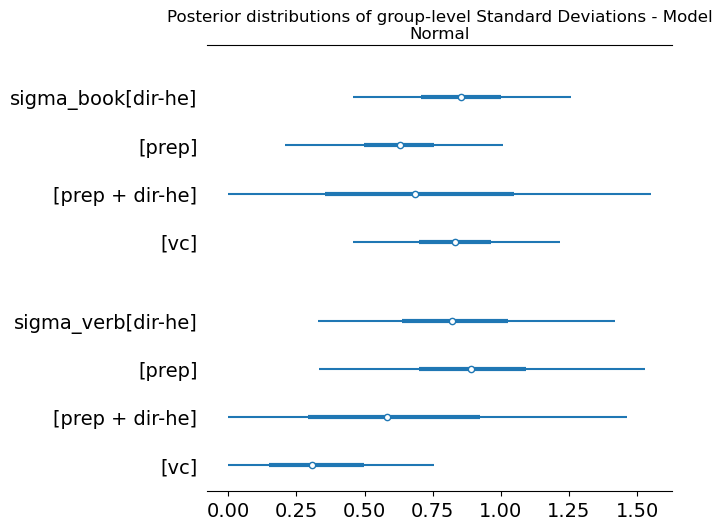

In [53]:
# Check pooling magnitude
az.plot_forest(idata, var_names=["sigma_book","sigma_verb"], combined=True)
plt.title("Posterior distributions of group-level Standard Deviations - Model Normal")  # give the plot a title
plt.show()

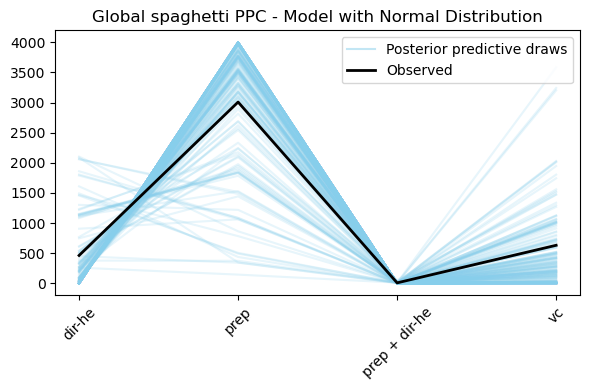

In [49]:
# Check model fit
y_sim = ppc.posterior_predictive["y_obs"].stack(sample=("chain","draw")).values
S, N = y_sim.shape
K = len(class_labels)

counts_obs = np.bincount(y, minlength=K)

plt.figure(figsize=(6, 4))

# Plot many spaghetti lines (no labels, to avoid clutter)
for s in range(min(200, S)):
    plt.plot(range(K), np.bincount(y_sim[s], minlength=K), color="skyblue", alpha=0.2)

# Plot a *single* invisible proxy line for the legend
plt.plot([], [], color="skyblue", alpha=0.5, label="Posterior predictive draws")

# Observed counts
plt.plot(range(K), counts_obs, color="black", lw=2, label="Observed")

plt.xticks(range(K), class_labels, rotation=45)
plt.title("Global spaghetti PPC - Model with Normal Distribution")
plt.legend()
plt.tight_layout()
plt.show()

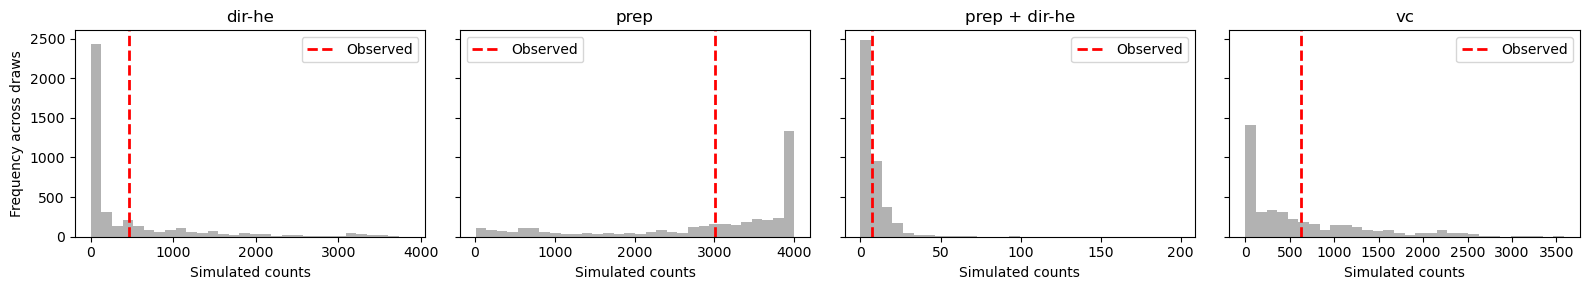

In [51]:
# check model fit with histogram for posterior draws
S, N = y_sim.shape
K = len(class_labels)
counts_obs = np.bincount(y, minlength=K)

# ---- Grid of panels: one histogram per class ----
cols = min(5, K)                       # up to 5 per row; tweak as you like
rows = int(np.ceil(K / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharey=True)
axes = np.atleast_1d(axes).ravel()

for k in range(K):
    sim_counts_k = (y_sim == k).sum(axis=1)         # (S,)
    ax = axes[k]
    ax.hist(sim_counts_k, bins=30, color="gray", alpha=0.6)
    ax.axvline(counts_obs[k], color="red", linestyle="--", lw=2, label="Observed")
    ax.set_title(class_labels[k])
    ax.set_xlabel("Simulated counts") # how many observations of class k are in a whole simulated dataset
    if k % cols == 0:
        ax.set_ylabel("Frequency across draws") # how often did a simulated dataset produce that count
    ax.legend()

# Hide any empty subplots if K doesn't fill the grid
for j in range(K, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [26]:
s = az.summary(idata, var_names=["alpha","sigma_book","sigma_verb"], round_to=2)
s
# mean column: the posterior mean of the parameter, expected value under the posterior distribution
# mean tells the average posterior estimate of the variation for the book or verb for each class

# sigma_books: how much book_scrolls differ from each other 
# in their baseline preference for that outcome class

# The next line shows only the rows where an effect is detected (0 present in the HDI)

#s[((s["hdi_3%"] < 0) & (s["hdi_97%"] < 0)) | ((s["hdi_3%"] > 0) & (s["hdi_97%"] > 0))]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[dir-he],-1.92,1.64,-5.11,1.06,0.02,0.03,4728.44,3092.52,1.00
alpha[prep],4.23,1.59,1.33,7.30,0.02,0.02,5288.58,3078.19,1.00
alpha[prep + dir-he],-2.76,1.70,-5.91,0.35,0.02,0.03,6107.83,3175.16,1.00
alpha[vc],0.42,1.58,-2.43,3.43,0.02,0.02,5182.50,3496.28,1.00
sigma_book[dir-he],0.84,0.24,0.40,1.28,0.01,0.01,393.91,300.99,1.02
sigma_book[prep],0.64,0.20,0.20,1.00,0.01,0.01,471.23,490.31,1.01
sigma_book[prep + dir-he],0.72,0.47,0.00,1.53,0.01,0.01,2129.21,2481.53,1.00
sigma_book[vc],0.83,0.21,0.47,1.22,0.01,0.01,788.79,613.63,1.00
sigma_verb[dir-he],0.84,0.29,0.35,1.46,0.01,0.01,1147.22,711.96,1.00
sigma_verb[prep],0.93,0.31,0.36,1.53,0.01,0.01,844.95,498.77,1.00


In [27]:
s = az.summary(idata, var_names=["verb_eff"], round_to=2)
s
s[((s["hdi_3%"] < 0) & (s["hdi_97%"] < 0)) | ((s["hdi_3%"] > 0) & (s["hdi_97%"] > 0))]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


In [28]:
# Summary of the effect of features (beta)

s = az.summary(idata, var_names=["beta"], round_to=2)
s[((s["hdi_3%"] < 0) & (s["hdi_97%"] < 0)) | ((s["hdi_3%"] > 0) & (s["hdi_97%"] > 0))]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[cmpl_complex_simple, dir-he]",1.58,0.80,0.13,3.10,0.01,0.01,3105.97,2584.90,1.0
"beta[cmpl_anim_anim, prep]",2.49,1.15,0.47,4.82,0.01,0.02,6524.37,2996.69,1.0
"beta[cmpl_indiv_adv, prep]",-2.39,1.00,-4.18,-0.45,0.01,0.02,4800.49,3616.57,1.0
"beta[cmpl_indiv_prsf, prep]",2.98,1.08,0.96,4.95,0.01,0.01,5773.15,3302.46,1.0
